# Project 3: Collaboration and competition

---

In this notebook, we start and interact with the environment to train agents which play tennis collaboratively.

### 1. Necessary imports and defining the constants

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [2]:
from collections import deque
import pickle

from IPython.core.debugger import set_trace

import numpy as np
import pandas as pd
import torch
from unityagents import UnityEnvironment
from tqdm import tqdm
import matplotlib.pyplot as plt

from d4pg_agent import Agent
import Config

%matplotlib inline 

# Initialize the config in which all hyperparams are stored
config = Config.config()

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env_file_name = 'Tennis_Windows_x86_64/Tennis.exe' # Path to the Unity environment.
n_episodes = 50000              # Number of episodes to train on
n_episodes_to_watch = 5         # Numbers of episodes to watch the trained agent

### 2. Setting up the environment and watch an untrained agent

In this step we start the environment, save the `brain_name`, which we need to interact with the environment and save the size of the state- and action-space.

In [3]:
env = UnityEnvironment(file_name=env_file_name)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

# number of actions
action_size = brain.vector_action_space_size

# dimension of the state-space 
num_agents = env_info.vector_observations.shape[0]
state_size = env_info.vector_observations.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


For comparison we'll let an agent take random actions and observe the score.

In [4]:
env_info = env.reset(train_mode=False)[brain_name]      # reset the environment    
states = env_info.vector_observations                   # get the current state (for each agent)
max_scores = -np.inf                                    # initialize the max score
for _ in range(5):
    scores = np.zeros(num_agents)                       # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            max_scores = np.max([max_scores, np.max(scores)]) # Update the max scores
            break
print(f"Overall best score: {max_scores:.3}")

Overall best score: 0.0


### 3. Train an agent

In the next code cells we initialize and train the agents. The trained model-parameters for the actor and critic will evaluated every 250 episodes and saved, every time a new best avg. score is achieved, in `checkpoint_xxx.pth`. 

To proof stability, training will be continued for 1000 more episodes.

Training will be done on the gpu if one is available.

If you just want to analyse already trained agents, you can skip this section.

In [5]:
def train_agent(n_episodes=10000):
    """Training the agents.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    scores_window.append(0)
    
    ep_after_solving = 1000
    env_solved = False
    best_mean_score = 0
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations
        score_1 = 0
        score_2 = 0
        
        # Decay the action-noise and reset the randomer
        # The action-noise is linear dependant of the avg. score. 
        # Score==0: eps=config.EPS_START
        # Score==0.3: eps=config.EPS_MIN
        new_eps = np.mean(scores_window)*(config.EPSILON_MIN-config.EPSILON_START)/.3 + config.EPSILON_START
        agent_1.epsilon = new_eps
        agent_2.epsilon = new_eps
        agent_1.noise.reset()
        agent_2.noise.reset()

        while True:
            
            # Select action
            action_1 = agent_1.act(np.expand_dims(state[0], 0))
            action_2 = agent_2.act(np.expand_dims(state[1], 0))

            action = [action_1, action_2]
            env_info = env.step(action)[brain_name]         # send the action to the environment
            next_state = env_info.vector_observations       # get the next state
            reward = env_info.rewards                       # get the reward
            done = env_info.local_done                      # see if episode has finished
            
            agent_1.step(state[0], action_1[0], reward[0], next_state[0], done[0])
            agent_2.step(state[1], action_2[0], reward[1], next_state[1], done[1])
          
            # Save the next_state as state and add the rewards to the current scores
            state = next_state
            score_1 += reward[0]
            score_2 += reward[1]
            if np.any(done): 
                break 

                
        scores_window.append(np.max([score_1, score_2]))       # save most recent score to the windowed score
        scores.append(np.max([score_1, score_2]))              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}\tLast Score: {:.2f}'.format(i_episode, np.mean(scores_window), scores[-1]), end="")
        if i_episode % 250 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
            # Save weights if the avg. score is higher than it ever was before
            if np.mean(scores_window) > best_mean_score:
                
                best_mean_score = np.mean(scores_window)
                torch.save(agent_1.critic_local.state_dict(), f"Results/checkpoint_agent_1_critic.pth")
                torch.save(agent_1.actor_local.state_dict(), f"Results/checkpoint_agent_1_actor.pth")
                torch.save(agent_2.critic_local.state_dict(), f"Results/checkpoint_agent_2_critic.pth")
                torch.save(agent_2.actor_local.state_dict(), f"Results/checkpoint_agent_2_actor.pth")

            # Saving Scores
            pickle.dump(scores, open(f"Results/Scores.pkl", 'wb'))
        
        # If the environment is solved the first time, save the current episode in env_solved
        if np.mean(scores_window)>=.3 and not env_solved:
            env_solved = i_episode
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        
        # Check if the after-run is finished and then stop training
        if env_solved and (i_episode >= env_solved + ep_after_solving  or (i_episode>=n_episodes+1)):
            break
    
    return scores

In [6]:
# Create the Agent and let it train
agent_1 = Agent(config, state_size, action_size, 1, seed=0)
agent_2 = Agent(config, state_size, action_size, 1, seed=1234)

# Train the agent and save the scores for later analysis
scores = train_agent(n_episodes=n_episodes)

Episode 250	Average Score: 0.01	Last Score: 0.00
Episode 500	Average Score: 0.01	Last Score: 0.00
Episode 750	Average Score: 0.01	Last Score: 0.00
Episode 1000	Average Score: 0.03	Last Score: 0.00
Episode 1250	Average Score: 0.01	Last Score: 0.00
Episode 1500	Average Score: 0.02	Last Score: 0.00
Episode 1750	Average Score: 0.04	Last Score: 0.10
Episode 2000	Average Score: 0.04	Last Score: 0.10
Episode 2250	Average Score: 0.03	Last Score: 0.00
Episode 2500	Average Score: 0.02	Last Score: 0.09
Episode 2750	Average Score: 0.01	Last Score: 0.00
Episode 3000	Average Score: 0.02	Last Score: 0.00
Episode 3250	Average Score: 0.02	Last Score: 0.10
Episode 3500	Average Score: 0.02	Last Score: 0.00
Episode 3750	Average Score: 0.01	Last Score: 0.10
Episode 4000	Average Score: 0.01	Last Score: 0.00
Episode 4250	Average Score: 0.02	Last Score: 0.09
Episode 4500	Average Score: 0.02	Last Score: 0.00
Episode 4750	Average Score: 0.01	Last Score: 0.00
Episode 5000	Average Score: 0.01	Last Score: 0.00
Epi

### 4. Whatch trained agents
Next we can watch a trained agent play tennis for `n_episodes_to_watch` episodes. Therefore we load the model-parameters, reset the environment and loop through the specified number of episodes only using the calculated actions without any random noise. 

In [ ]:
agent_1 = Agent(config, state_size, action_size, 1, seed=0)
agent_2 = Agent(config, state_size, action_size, 1, seed=1234)

agent_1.actor_local.load_state_dict(torch.load("Results/checkpoint_agent_1_actor.pth", map_location=agent_1.config.device))
agent_1.critic_local.load_state_dict(torch.load("Results/checkpoint_agent_1_critic.pth", map_location=agent_1.config.device))
agent_2.actor_local.load_state_dict(torch.load("Results/checkpoint_agent_2_actor.pth", map_location=agent_2.config.device))
agent_2.critic_local.load_state_dict(torch.load("Results/checkpoint_agent_2_critic.pth", map_location=agent_2.config.device))

agent_1.is_training = False
agent_2.is_training = False

scores = []                            # list containing scores from each episode
best_score = -np.inf                   # initialize the best score
for i_episode in range(1, n_episodes_to_watch+1):    # Loop through five episodes
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations
    score_1 = 0
    score_2 = 0
    
    while True:
        action_1 = agent_1.act(np.expand_dims(state[0], 0))
        action_2 = agent_2.act(np.expand_dims(state[1], 0))

        action = [action_1, action_2]
        env_info = env.step(action)[brain_name]         # send the action to the environment
        
        state = env_info.vector_observations            # get the new state
        reward = env_info.rewards                       # get the reward
        done = env_info.local_done                      # see if episode has finished
        
        score_1 += reward[0]
        score_2 += reward[1]
        
        if np.any(done):
            break 
    temp_score = np.max([score_1, score_2])
    if temp_score > best_score:
        best_score = temp_score
    scores.append(temp_score)                           # save most recent score

print(f"Avg. score: {np.mean(scores):.3}, Max score: {best_score}")

### 5. Plot the learning-curve
In the last section we want to take a look at the learning curve. For orientation the goal-score (30) is also plottet.

Text(0, 0.5, 'Score')

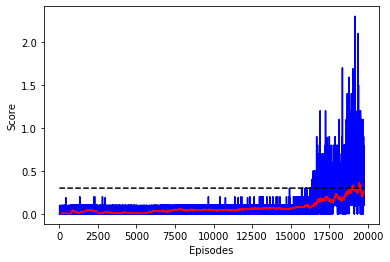

In [5]:
training_scores = pickle.load(open(f"Results/Scores.pkl", 'rb'))
scores_ma = pd.DataFrame(training_scores).rolling(window=100).mean()
plt.plot(range(1, len(training_scores)+1), training_scores, 'b')
plt.plot(scores_ma.index.values, scores_ma.values, 'r')
plt.plot(np.ones(len(training_scores))*.3, 'k--')
plt.xlabel('Episodes')
plt.ylabel('Score')

### 6. Close the environment

In [ ]:
env.close()